In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
from math import sqrt
from scipy.signal import argrelextrema
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import seaborn
from Cleaning_Data import get_X , get_y
from Cleaning_Data import read_csv
from Cleaning_Data import *

pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 10000)
pd.set_option('display.width', 10000)
seaborn.set()

# The output template
OUTPUT_TEMPLATE_CLASSIFIER = (
    'Bayesian classifier: {bayes:.3g}\n'
    'kNN classifier:      {knn:.3g}\n'
    'SVM classifier:      {svc:.3g}\n'
    'Neural Networks classifier:  {nn:.3g}\n'
)

# Machine Learning 

In [67]:
def ML_classifier(X, y):
    
    # Comment the train_test_split because we want to know for given a training and valid data, model's performance
    # X_train , X_valid, y_train, y_valid = train_test_split(X, y)
    
    model_bayes = make_pipeline(
        StandardScaler(),
        GaussianNB()
    )
    model_knn = make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors = 5)
    )
    model_svc = make_pipeline(
        StandardScaler(),
        SVC(kernel = 'linear' , C = 20)
    )
    model_nn = make_pipeline(
        MLPClassifier(solver = 'lbfgs', hidden_layer_sizes = (10,10,10,10), activation = 'logistic')
    )
    
    # Store the models in list. Exercise 8 method 
    models = [model_bayes , model_knn , model_svc , model_nn]
    for i , m in enumerate(models):
        m.fit(X_train , y_train)
    
    # Show score
    print(OUTPUT_TEMPLATE_CLASSIFIER.format(
        bayes = model_bayes.score(X_valid , y_valid),
        knn = model_knn.score(X_valid , y_valid),
        svc = model_svc.score(X_valid , y_valid),
        nn = model_nn.score(X_valid , y_valid)
    ))

In [68]:
'''
should write in main function
'''
data = pd.read_csv('feature_df.csv')
y = data['catogary']
del data['catogary']
X = data
X_train , X_valid, y_train, y_valid = train_test_split(X, y)

In [69]:
ML_classifier(X , y)

Bayesian classifier: 0.778
kNN classifier:      0.667
SVM classifier:      0.815
Neural Networks classifier:  0.296



# Downstairs and upstairs analysis 

In [70]:
def get_stairs_data(down_or_up):
    '''
    Get the total acceleration data of downstair and upstairs 
    If parameter is 'down' , generate downstairs data, otherwise generate upstairs data
    The data we return is AFTER the Butterworth filter
    Return dataFrame only contain one columns data['aT']
    '''
    data = pd.DataFrame()
    if down_or_up == 'down':
        # created a dataFrame first and then do the plus step, actually similar to do-while loop
        data['aT'] = Butterworth_filter_forplot(read_csv('downstairs_inpocket' , 'downstairs_inpocket' + str(1)))['aT']
        for i in range(2 , 16):
            data['aT'] += Butterworth_filter_forplot(read_csv('downstairs_inpocket' , 'downstairs_inpocket' + str(i)))['aT']
    else:
        # # created a dataFrame first and then do the plus step, actually similar to do-while loop
        data['aT'] = Butterworth_filter_forplot(read_csv('upstairs_inpocket' , 'upstairs_inpocket' + str(1)))['aT']
        for i in range(2 , 16):
            data['aT'] += Butterworth_filter_forplot(read_csv('upstairs_inpocket' , 'upstairs_inpocket' + str(i)))['aT']
    # drop the data with NaN value 
    data = data.dropna()
    # Get the average
    data = data / 15
    return data

In [71]:
#data_show = get_stairs_data('up')
#print(data_show)

In [96]:
def analysis_stairs(data_down , data_up):
    '''
    
    '''
    # plot the total acceleration of downstairs and upstairs
    plt.figure(figsize = (30, 30))
    plt.subplot(3, 1, 1)
    plt.plot(data_down['aT'] , 'rx' , alpha = 0.5)
    plt.ylabel('Acceleration(m/s^2)')
    plt.title('Downstairs total acceleration')
    plt.subplot(3, 1, 2)
    plt.plot(data_up['aT'] , 'bx' , alpha = 0.5)
    plt.ylabel('Acceleration(m/s^2)')
    plt.title('Upstairs total acceleration')
    plt.subplot(3, 1, 3)
    plt.plot(data_down['aT'] , 'rx' , alpha = 0.5)
    plt.plot(data_up['aT'] , 'bx' , alpha = 0.5)
    plt.ylabel('Acceleration(m/s^2)')
    plt.legend(['Downstairs total acceleration' , 'Upstairs total acceleration'])
    plt.savefig('Down_up_stairs_plot.png')
    
    # plot the histogram of total acceleration of downstairs and upstairs 
    plt.figure(figsize = (5, 5))
    plt.hist(data_down['aT'])
    plt.hist(data_up['aT'])
    plt.xlabel('Acceleration(m/s^2)')
    plt.ylabel('quantity')
    plt.legend(['Downstairs' , 'Upstairs'])
    
    # Normal test for downstairs total acceleration 8.743499021186031e-29 , 1.81682954145173e-19 and it means not normal for both 
    downstairs_normal_pvalue = stats.normaltest(data_down['aT']).pvalue
    upstairs_normal_pvalue = stats.normaltest(data_up['aT']).pvalue
    print('downstairs_normal_pvalue:' , downstairs_normal_pvalue)
    print('upstairs_normal_pvalue:' , upstairs_normal_pvalue)
   
    # Equal variance test for downstairs total acceleration 0.0038097361243232533 , not equal variance 
    equal_variance = stats.levene(data_down['aT'] , data_up['aT']).pvalue 
    print('equal variance pvalue:' , equal_variance)
    
    # T-test to figure out whether downstairs and upstairs total acceleration have equal mean and parameter we give
    # equal_var = False we didn't pass the equal variance test 
    # 3.7445904606784945e-25 not equal mean 
    t_test_pvalue = stats.ttest_ind(data_down['aT'] , data_up['aT'] , equal_var = False).pvalue
    print('t_test_pvalue:' , t_test_pvalue)

downstairs_normal_pvalue: 8.743499021186031e-29
upstairs_normal_pvalue: 1.81682954145173e-19
equal variance pvalue: 0.0038097361243232533
t_test_pvalue: 3.7445904606784945e-25


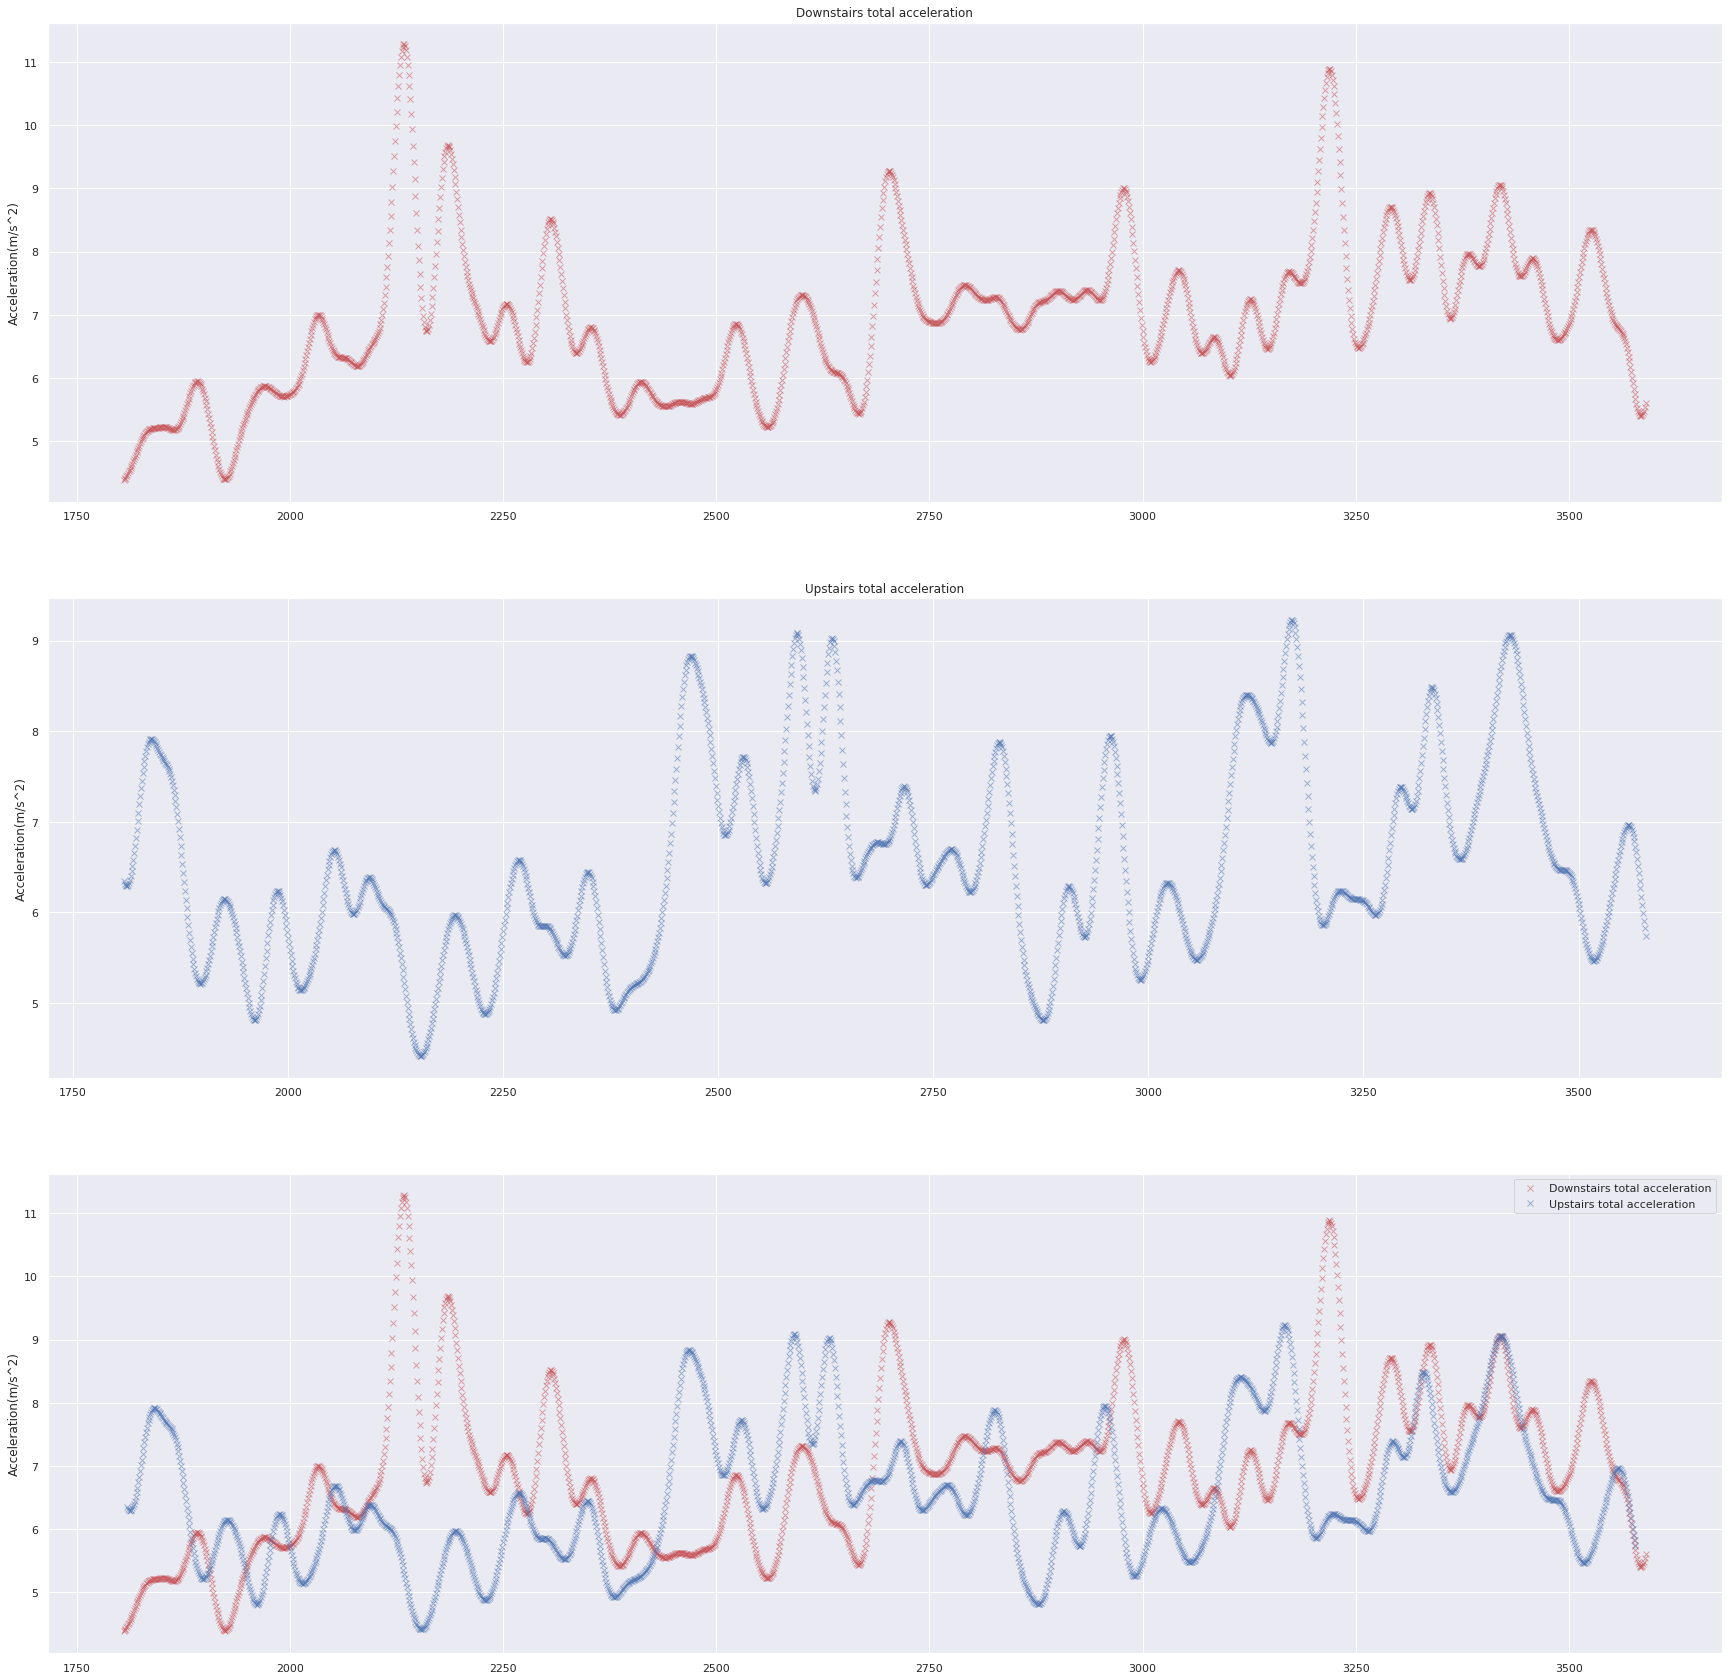

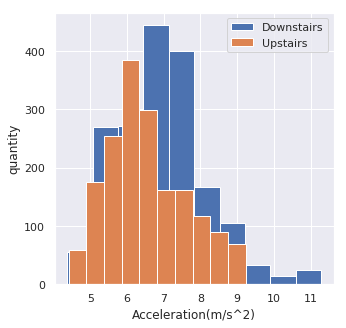

In [98]:
'''
should write in main() , now for test
'''
data_down = get_stairs_data('down')
data_up = get_stairs_data('up')
analysis_stairs(data_down , data_up)